<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/spectrum_laplace_operator/spectrum_laplace_operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [1]:
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn

## Detect available device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Definition of an activation function and its derivatives

In [3]:
def f0(x):
    return torch.tanh(x)
  
def f1(x):
  return 1/torch.cosh(x)**2
  
def f2(x):
  return -2*torch.sinh(x)/torch.cosh(x)**3

## Class for the perceptron-wavefunction 

In [4]:
class WaveFunction(nn.Module):

  def __init__(self, N, layersizes):
    self.N = N  # size of the input vector
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers

    super(WaveFunction, self).__init__()
        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    
    self.h = [None] * (self.l + 1)  # outputs of the layers

  
  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
      
    return self.h[-1]


  def grad(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers #
    gradient = torch.zeros(x.shape) #[None] * self.N #
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device) #
      dh_dx[t] = 1 # 

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
        
      # print(dh_dx.shape, gradient[t].shape)
      
      gradient[:,t] = dh_dx.reshape(-1)

    return gradient
  

  def laplac(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    y = self.forward(x)  # computes outputs of the layers
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device)
      dh_dx[t] = 1

      d2h_dx2 = torch.zeros(self.N).to(device)

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative

        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      
      # print(d2h_dx2)
      laplacian += d2h_dx2
    
    return laplacian

In [83]:
def A(x_):
  p = torch.ones(x_.shape[0]).to(device)

  for i in range(x_.shape[1]):
    p *= (x_[:,i] - 1/2)**2-1/4

  return p
  
def Ax(x_):
  p = torch.ones(x_.shape).to(device)

  for i in range(x_.shape[1]):
    p[:, i] = A(x_) * 2 * (x_[:,i] - 1/2) / ((x_[:,i] - 1/2)**2-1/4)

  return p
  
def Axx(x_):
  return 2 * A(x_) * torch.sum( ((x_ - 1/2)**2 - 1/4)**(-1), axis=1 )

def train_loop(N, N_batch, M, wf, optimizer, eigval):
  """
  N --- a size of the input vector, its dimension
  M --- total number of iterations
  """

  loss_fn = nn.L1Loss()
  
  for i in range(M):
    x_test = torch.rand((N_batch, N)).to(device)

    phi_test = wf(x_test).reshape(len(x_test)).to(device)
    phix_test = wf.grad(x_test).to(device)
    phixx_test = wf.laplac(x_test).reshape(len(x_test)).to(device)

    # если задавать нужное значение энергии, то всё получается
    I = torch.mean( (phixx_test * A(x_test) \
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) \
                     + Axx(x_test) * phi_test \
                     + eigval*phi_test*A(x_test))**2 )

    # Compute loss
    loss = loss_fn(I, torch.tensor(0.0, device=device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if np.isnan(loss.item()):
      print(f'{i:} LOSS FUNCTION IS NAN')
      break

    if (i+1) % 100 == 0:
      print(f"Residual: {loss.item():>0.4E} [{i+1:>5d} / {M:>5d}]")

# 1D

In [84]:
def plot_compar_1d(wf):
  x = torch.linspace(1e-2,1-1e-2,100).reshape((-1, N)).to(device)
  y = wf(x) * A(x).reshape((-1,N))

  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()

  plt.plot(x, (y/y.mean())**2,
           label='What we get')
  
  plt.plot(x, (np.sin(x*np.pi)/np.sin(x*np.pi).mean())**2,
           label='What we should get')

  plt.legend()
  plt.xlim(0,1)
  plt.ylim(0.0,None)

  plt.show()

## Initialization of our wavefunction

In [94]:
N = 1  # size of the input vector
wf = WaveFunction(N, [10]*3).to(device) ## число внутренних слоёв должно быть той же четности, что и номер состояния

## Its training


 Epoch 1
-------------------------------
Residual: 1.3118E-04 [  100 /  1000]
Residual: 5.3538E-05 [  200 /  1000]
Residual: 1.0324E-05 [  300 /  1000]
Residual: 6.0846E-07 [  400 /  1000]
Residual: 7.1805E-07 [  500 /  1000]
Residual: 1.2815E-06 [  600 /  1000]
Residual: 6.4082E-07 [  700 /  1000]
Residual: 7.4397E-07 [  800 /  1000]
Residual: 9.4473E-07 [  900 /  1000]
Residual: 1.8975E-06 [ 1000 /  1000]


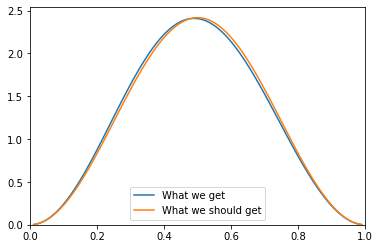


 Epoch 2
-------------------------------
Residual: 4.7976E-07 [  100 /  1000]
Residual: 8.5779E-07 [  200 /  1000]
Residual: 6.3946E-07 [  300 /  1000]
Residual: 8.5492E-07 [  400 /  1000]
Residual: 5.7029E-07 [  500 /  1000]
Residual: 8.5123E-07 [  600 /  1000]
Residual: 1.4085E-06 [  700 /  1000]
Residual: 6.8628E-07 [  800 /  1000]
Residual: 1.3469E-06 [  900 /  1000]
Residual: 9.3418E-07 [ 1000 /  1000]

 Epoch 3
-------------------------------
Residual: 4.6640E-07 [  100 /  1000]
Residual: 1.4796E-06 [  200 /  1000]
Residual: 1.3599E-06 [  300 /  1000]
Residual: 1.8282E-06 [  400 /  1000]
Residual: 1.1435E-06 [  500 /  1000]
Residual: 8.8903E-07 [  600 /  1000]
Residual: 1.1772E-06 [  700 /  1000]
Residual: 8.4438E-07 [  800 /  1000]
Residual: 1.0387E-06 [  900 /  1000]
Residual: 7.8845E-07 [ 1000 /  1000]


In [95]:
optimizer = torch.optim.SGD(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 3
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10, 1000, wf, optimizer, np.pi**2)
  scheduler.step()

  if (t+1) % 5 == 0 or t == 0:
    plot_compar_1d(wf)

# 2D

In [96]:
def plot_compare_2d(wf):
  n = 100 # number of points over one dimension
  x = np.linspace(0,1,n)
  xs, ys = np.meshgrid(x,x, sparse=True)
  
  X = np.array([[xs[0,i], ys[j,0]] for i in range(100) for j in range(100)])
  X = torch.tensor(X).to(device)

  phi = wf(X.float()) * A(X.float())
  sin = torch.sin(np.pi*X[:,0].float())*torch.sin(np.pi*X[:,1].float())

  fig, ax = plt.subplots(1, 2, figsize=(14,5))

  pcm0 = ax[0].contourf(x, x, Z.reshape(100,100).cpu().detach().numpy()**2)

  fig.colorbar(pcm0, ax=ax[0], extend='max')

  pcm1 = ax[1].contourf(x, x, sin.reshape(100,100).cpu().detach().numpy()**2)

  fig.colorbar(pcm1, ax=ax[1], extend='max')

  ax[0].set_xlabel(r'$x_1$')
  ax[0].set_ylabel(r'$x_2$')

  ax[1].set_xlabel(r'$x_1$')
  ax[1].set_ylabel(r'$x_2$')

  ax[0].set_title(r'What $|\psi|^2$ we get')
  ax[1].set_title(r'What $|\psi|^2$ we should get')

  plt.show()

In [97]:
N = 2
wf = WaveFunction(N, [10**N]*3).to(device) 


 Epoch 1
-------------------------------
Residual: 8.3712E-04 [  100 /  1000]
Residual: 3.5777E-04 [  200 /  1000]
Residual: 1.0977E-04 [  300 /  1000]
Residual: 4.2258E-05 [  400 /  1000]
Residual: 1.4395E-05 [  500 /  1000]
Residual: 6.0561E-06 [  600 /  1000]
Residual: 2.4618E-06 [  700 /  1000]
Residual: 1.0178E-06 [  800 /  1000]
Residual: 7.7023E-07 [  900 /  1000]
Residual: 6.4374E-07 [ 1000 /  1000]


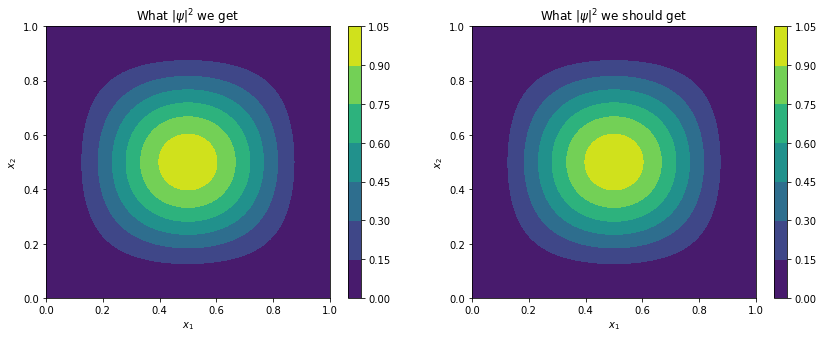


 Epoch 2
-------------------------------
Residual: 7.4335E-07 [  100 /  1000]
Residual: 8.7904E-07 [  200 /  1000]
Residual: 7.1658E-07 [  300 /  1000]
Residual: 7.6845E-07 [  400 /  1000]
Residual: 8.7367E-07 [  500 /  1000]
Residual: 7.1627E-07 [  600 /  1000]
Residual: 5.4514E-07 [  700 /  1000]
Residual: 6.7068E-07 [  800 /  1000]
Residual: 5.6532E-07 [  900 /  1000]
Residual: 5.8050E-07 [ 1000 /  1000]

 Epoch 3
-------------------------------
Residual: 6.4408E-07 [  100 /  1000]
Residual: 6.0032E-07 [  200 /  1000]
Residual: 6.5902E-07 [  300 /  1000]
Residual: 7.0187E-07 [  400 /  1000]
Residual: 7.0856E-07 [  500 /  1000]
Residual: 7.3123E-07 [  600 /  1000]
Residual: 5.1443E-07 [  700 /  1000]
Residual: 6.5745E-07 [  800 /  1000]
Residual: 1.0024E-06 [  900 /  1000]
Residual: 5.9317E-07 [ 1000 /  1000]

 Epoch 4
-------------------------------
Residual: 5.0422E-07 [  100 /  1000]
Residual: 8.2733E-07 [  200 /  1000]
Residual: 6.3483E-07 [  300 /  1000]
Residual: 7.8016E-07 [ 

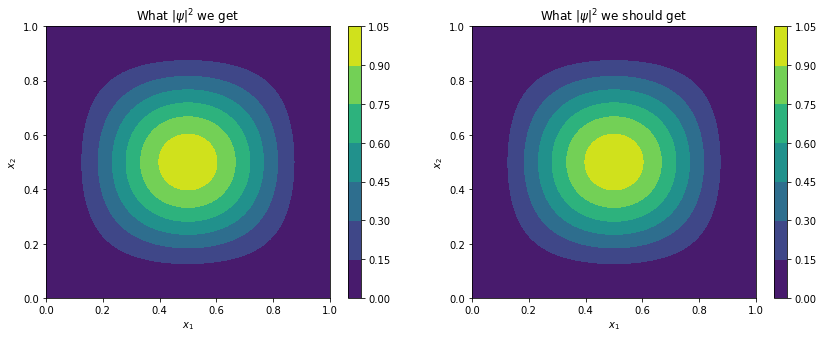

In [98]:
optimizer = torch.optim.SGD(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 5
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer, 2*np.pi**2)
  scheduler.step()

  if (t+1) % 5 == 0 or t == 0:
    # print('AAAAA')
    plot_compare_2d(wf)

# 3D

In [103]:
N = 3
wf = WaveFunction(N, [100]*3).to(device)  # <--- here you should consider a case
# when 100 -> 10**N

In [104]:
optimizer = torch.optim.SGD(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 5
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 500, wf, optimizer, 3*np.pi**2)
  scheduler.step()


 Epoch 1
-------------------------------
Residual: 1.7615E-05 [  100 /   500]
Residual: 1.8910E-05 [  200 /   500]
Residual: 1.9225E-05 [  300 /   500]
Residual: 1.9134E-05 [  400 /   500]
Residual: 1.7491E-05 [  500 /   500]

 Epoch 2
-------------------------------
Residual: 1.7117E-05 [  100 /   500]
Residual: 1.7174E-05 [  200 /   500]
Residual: 1.4661E-05 [  300 /   500]
Residual: 1.5758E-05 [  400 /   500]
Residual: 1.5386E-05 [  500 /   500]

 Epoch 3
-------------------------------
Residual: 1.6538E-05 [  100 /   500]
Residual: 1.4583E-05 [  200 /   500]
Residual: 1.6255E-05 [  300 /   500]
Residual: 1.5082E-05 [  400 /   500]
Residual: 1.3694E-05 [  500 /   500]

 Epoch 4
-------------------------------
Residual: 1.4020E-05 [  100 /   500]
Residual: 1.4543E-05 [  200 /   500]
Residual: 1.3067E-05 [  300 /   500]
Residual: 1.3271E-05 [  400 /   500]
Residual: 1.2002E-05 [  500 /   500]

 Epoch 5
-------------------------------
Residual: 1.2578E-05 [  100 /   500]
Residual: 1.2